In [7]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Loading the Telco Churn dataset from the  IBM Base Samples to predict if someone will stop using the services 

In [8]:
df = pd.read_excel(r'C:\Users\Tibi\Desktop\notebooks\xgboost\Telco_customer_churn.xlsx')

In [9]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [10]:
# removing columns where there are valzes for only people who left the service 
df.drop(['Churn Label','Churn Score','CLTV','Churn Reason'],axis=1,inplace=True) # axis=0 removes rows, 1 removes columns, inplace to modify the existing df
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [11]:
df['Count'].unique()

array([1], dtype=int64)

In [12]:
df['Country'].unique()

array(['United States'], dtype=object)

In [13]:
df['State'].unique()

array(['California'], dtype=object)

In [14]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [15]:
# dropping columns where there is only one value, costumerID since its different for every individual and Lat Long, since there are separate columns for them
df.drop(['Count','Country','State','CustomerID','Lat Long'],axis=1,inplace=True)

In [16]:
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [17]:
df['City'].replace(' ','-',regex=True,inplace=True)

In [18]:
df['City'].unique()[0:10]

array(['Los-Angeles', 'Beverly-Hills', 'Huntington-Park', 'Lynwood',
       'Marina-Del-Rey', 'Inglewood', 'Santa-Monica', 'Torrance',
       'Whittier', 'La-Habra'], dtype=object)

In [19]:
df.columns=df.columns.str.replace(' ','_')

In [20]:
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los-Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los-Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los-Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los-Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los-Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [21]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [22]:
df['Total_Charges'].unique() #dtype is object but it should be a number type

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [23]:
df['Total_Charges']=pd.to_numeric(df['Total_Charges']) # cant convert to numeric because of missing values

ValueError: Unable to parse string " " at position 2234

In [24]:
len(df.loc[df['Total_Charges']==' ']) # 11 indexes with missing value

11

In [25]:
df.loc[df['Total_Charges']==' '] # we can see these people just signed up, because tenure months is 0, so we set these values to 0

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San-Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San-Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los-Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun-City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben-Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La-Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [26]:
df.loc[(df['Total_Charges']== ' '), 'Total_Charges'] =0

In [27]:
df.loc[df['Total_Charges']==0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San-Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San-Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los-Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun-City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben-Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La-Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


In [28]:
df['Total_Charges']=pd.to_numeric(df['Total_Charges'])

In [29]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [30]:
df.replace(' ','_', regex=True,inplace=True) # for drawing the tree
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los-Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los-Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los-Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los-Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los-Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


We want the dependent variable y to be the Churn value, which is 1 for people who left, 0 who didnt

In [31]:
X= df.drop('Churn_Value',axis=1).copy() 
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los-Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los-Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los-Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los-Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los-Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [32]:
y=df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

In [33]:
X.dtypes # one-hot encoding categorical data
# converting categorical data to continuos is not good, since for example if we converted categories to numbers 1,2,3,4, 
# the algorithm might assume the distance between these numbers are equal and group them together
# columntranformer from scikit learn can be used or pandas get_dummies, former is more consistent while the latter has better visuals keeping the names of the columns

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

In [34]:
pd.get_dummies(X,columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los-Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,False,False,False,True
1,Los-Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,False,False,True,False
2,Los-Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,False,False,True,False
3,Los-Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,False,False,True,False
4,Los-Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,True,False,False,False


In [35]:
X_encoded=pd.get_dummies(X, columns=['City','Gender','Senior_Citizen','Partner','Dependents','Phone_Service','Multiple_Lines','Internet_Service'
                                     ,'Online_Security','Online_Backup','Device_Protection','Tech_Support','Streaming_TV','Streaming_Movies','Contract',
                                     'Paperless_Billing','Payment_Method'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,2,70.70,151.65,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
2,90006,34.048013,-118.293953,8,99.65,820.50,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
3,90010,34.062125,-118.315709,28,104.80,3046.05,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
4,90015,34.039224,-118.266293,49,103.70,5036.30,False,False,False,False,...,True,True,False,False,False,True,True,False,False,False


In [36]:
y.unique()

array([1, 0], dtype=int64)

We can see that the data is imbalanced, since only 26.5% people left the company

In [37]:
sum(y)/len(y) 

0.2653698707936959

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X_encoded,y,random_state=43,stratify=y) # stratify=y so after the split the ratio of pos/neg examples remain the same
# 75% of data in train

In [39]:
sum(y_train)/len(y_train)

0.2654297614539947

In [40]:
sum(y_test)/len(y_test)

0.26519023282226006

In [41]:
xgb_model=xgb.XGBClassifier(objective='binary:logistic',seed=42,early_stopping_rounds=10,eval_metric='aucpr')
xgb_model.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.68176
[1]	validation_0-aucpr:0.69720
[2]	validation_0-aucpr:0.70295
[3]	validation_0-aucpr:0.71366
[4]	validation_0-aucpr:0.71953
[5]	validation_0-aucpr:0.71851
[6]	validation_0-aucpr:0.72184
[7]	validation_0-aucpr:0.72124
[8]	validation_0-aucpr:0.72267
[9]	validation_0-aucpr:0.72120
[10]	validation_0-aucpr:0.72139
[11]	validation_0-aucpr:0.72234
[12]	validation_0-aucpr:0.71648
[13]	validation_0-aucpr:0.71685
[14]	validation_0-aucpr:0.71627
[15]	validation_0-aucpr:0.71700
[16]	validation_0-aucpr:0.71662
[17]	validation_0-aucpr:0.71680
[18]	validation_0-aucpr:0.71619


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
y_pred=xgb_model.predict(X_test)

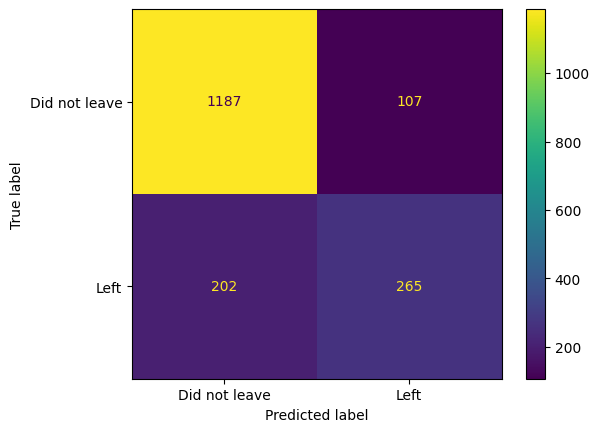

In [43]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_pred,values_format='d',display_labels=['Did not leave','Left'])

Because of the imbalance of the data we can see that the people who left the company were not correctly classified. 
Total accuracy is TP + TN / P + N = 82%, but TNR(true negative rate)= TN/N=265/202+265=56% only, with FPS=1-TNR=44%
TPR is good -> TPR= TP/P=91%
Balanced accuracy: TPR + TNR /2= 73.5%


scale_pos_weight adds a penalty for negatively classifying the minority class

In [58]:
param_grid={'max_depth':[3,4,5],
            'learning_rate':[0.1,0.01,0.05],
            'gamma':[0,0.25,1.0],
            'reg_lambda':[0,1.0,10.0],
            'scale_pos_weight':[1,3,5]}
# subsample= 0.9 only uses a random subset of the data, and colsample_bytree=0.5 only uses half the columns per tree to speed up calculations and prevent overfitting
optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',seed=42,subsample=0.9,colsample_bytree=0.5,eval_metric='auc',early_stopping_rounds=10),
                            param_grid=param_grid,scoring='roc_auc',verbose=2,cv=3)

In [59]:
optimal_params.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=True)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-auc:0.81900
[1]	validation_0-auc:0.83944
[2]	validation_0-auc:0.85699
[3]	validation_0-auc:0.86070
[4]	validation_0-auc:0.86361
[5]	validation_0-auc:0.86495
[6]	validation_0-auc:0.86647
[7]	validation_0-auc:0.86650
[8]	validation_0-auc:0.86812
[9]	validation_0-auc:0.86756
[10]	validation_0-auc:0.86902
[11]	validation_0-auc:0.87007
[12]	validation_0-auc:0.87008
[13]	validation_0-auc:0.86993
[14]	validation_0-auc:0.86985
[15]	validation_0-auc:0.87029
[16]	validation_0-auc:0.87044
[17]	validation_0-auc:0.87021
[18]	validation_0-auc:0.87124
[19]	validation_0-auc:0.87187
[20]	validation_0-auc:0.87236
[21]	validation_0-auc:0.87301
[22]	validation_0-auc:0.87291
[23]	validation_0-auc:0.87286
[24]	validation_0-auc:0.87301
[25]	validation_0-auc:0.87365
[26]	validation_0-auc:0.87345
[27]	validation_0-auc:0.87398
[28]	validation_0-auc:0.87429
[29]	validation_0-auc:0.87443
[30]	validation_0-auc:0.87483
[31]	validation_0

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=2)

In [62]:
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 1.0,
 'scale_pos_weight': 1}

In [66]:
param_grid2={'max_depth':[4],
            'learning_rate':[0.1,0.5,1.0],
            'gamma':[0.25],
            'reg_lambda':[1.0,5.0,10.0],
            'scale_pos_weight':[3]} # documentation: sum(neg_instances)/sum(pos_instances)

In [67]:
optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',seed=42,subsample=0.9,colsample_bytree=0.5,eval_metric='auc',early_stopping_rounds=10),
                            param_grid=param_grid2,scoring='roc_auc',verbose=2,cv=3)

In [68]:
optimal_params.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-auc:0.82647
[1]	validation_0-auc:0.84919
[2]	validation_0-auc:0.86770
[3]	validation_0-auc:0.87049
[4]	validation_0-auc:0.87160
[5]	validation_0-auc:0.87257
[6]	validation_0-auc:0.87195
[7]	validation_0-auc:0.87201
[8]	validation_0-auc:0.87301
[9]	validation_0-auc:0.87231
[10]	validation_0-auc:0.87257
[11]	validation_0-auc:0.87305
[12]	validation_0-auc:0.87230
[13]	validation_0-auc:0.87210
[14]	validation_0-auc:0.87312
[15]	validation_0-auc:0.87428
[16]	validation_0-auc:0.87376
[17]	validation_0-auc:0.87377
[18]	validation_0-auc:0.87479
[19]	validation_0-auc:0.87481
[20]	validation_0-auc:0.87508
[21]	validation_0-auc:0.87496
[22]	validation_0-auc:0.87488
[23]	validation_0-auc:0.87502
[24]	validation_0-auc:0.87546
[25]	validation_0-auc:0.87605
[26]	validation_0-auc:0.87547
[27]	validation_0-auc:0.87550
[28]	validation_0-auc:0.87591
[29]	validation_0-auc:0.87604
[30]	validation_0-auc:0.87630
[31]	validation_0-au

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.25], 'learning_rate': [0.1, 0.5, 1.0],
                         'max_depth': [4], 'reg_lambda': [1.0, 5.0, 10.0],
                         'scale_pos_weight': [3]},
             scoring='roc_auc', verbose=2)

In [69]:
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 3}

Retraining network with parameters obtained from gridsearch

In [70]:
xgb_model2=xgb.XGBClassifier(objective='binary:logistic',seed=42,early_stopping_rounds=10,eval_metric='aucpr',
                             gamma=0.25,learning_rate=0.1,max_depth=4,reg_lambda=10.0,scale_pos_weight=3)
xgb_model2.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.63922
[1]	validation_0-aucpr:0.66110
[2]	validation_0-aucpr:0.66994
[3]	validation_0-aucpr:0.67918
[4]	validation_0-aucpr:0.68392
[5]	validation_0-aucpr:0.68235
[6]	validation_0-aucpr:0.68431
[7]	validation_0-aucpr:0.68327
[8]	validation_0-aucpr:0.69727
[9]	validation_0-aucpr:0.70019
[10]	validation_0-aucpr:0.70403
[11]	validation_0-aucpr:0.70467
[12]	validation_0-aucpr:0.70545
[13]	validation_0-aucpr:0.70449
[14]	validation_0-aucpr:0.70538
[15]	validation_0-aucpr:0.71092
[16]	validation_0-aucpr:0.71214
[17]	validation_0-aucpr:0.71794
[18]	validation_0-aucpr:0.71845
[19]	validation_0-aucpr:0.71804
[20]	validation_0-aucpr:0.71705
[21]	validation_0-aucpr:0.71686
[22]	validation_0-aucpr:0.71793
[23]	validation_0-aucpr:0.71891
[24]	validation_0-aucpr:0.71877
[25]	validation_0-aucpr:0.71875
[26]	validation_0-aucpr:0.71917
[27]	validation_0-aucpr:0.71978
[28]	validation_0-aucpr:0.71833
[29]	validation_0-aucpr:0.71924
[30]	validation_0-aucpr:0.71918
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
y_pred2=xgb_model2.predict(X_test)

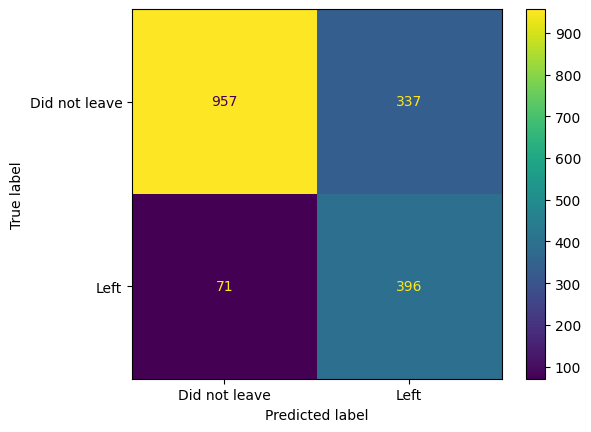

In [73]:
cm=ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_pred2,values_format='d',display_labels=['Did not leave','Left'])

As we can see, the negative examples were classified at a much higher rate, but at the cost of worse classification of the positive examples. However, the negative example classification is more important regarding this dataset

TNR= 85% now, TPR= 73% (down by a lot), ACC= 76.5%, Balanced ACC=79%

precision or PPV(positive predictive value)= true positives/ predicted positives = 957 /957+71 = 93% , Negative predictive value = TN/PN = 396/396 + 337 = 54% 
TP = 957, TN= 396 , FP= 71, FN= 337, MCC(Matthews correlation coeff)= TP x TN - FP x FN / sqrt((TP + FP)x(TP + FN)x(TN + FP)x(TN + FN)) = 0.52(from -1 to +1, where +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation)

In [84]:
import math
TP= 957
TN= 396
FP=71
FN=337
MCC= ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print(MCC)

0.526149640359264
